# Transformation matrix

We need to calculate and store a transformation matrix that can be used for mapping all rgb images to the irccam perspective. See the `camera-mapping.ipynb` notebook for more details on the SIFT/RANSAC approach we use here.

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.abspath(''), '..'))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

from datasets.create_dataset import rotate_image, timestamp_to_idx, normalize_irccam_image, \
    get_irccam_bt_data, get_vis_img, process_irccam_img, process_vis_img

In [2]:
def plot_img(img):
    figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
    implot = plt.imshow(img, cmap='gray')
    

In [3]:
timestamp = '20180112140000'
vis_img = get_vis_img(timestamp)
vis_img = process_vis_img(vis_img)
# plot_img(vis_img)
ir_img = get_irccam_bt_data(timestamp)
ir_img = process_irccam_img(ir_img)
# plot_img(ir_img)

61


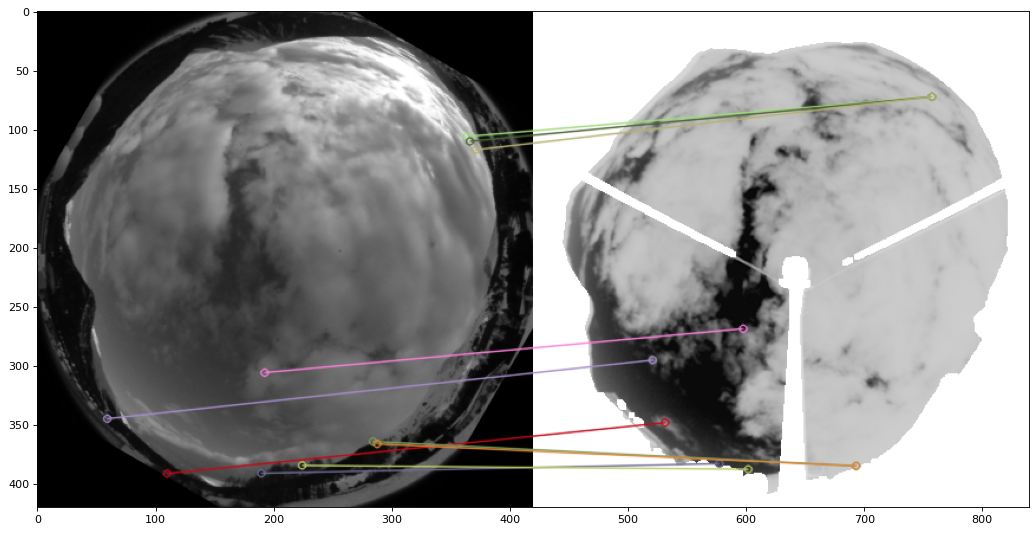

In [7]:
import cv2

def ir_to_gray(img):
    mi = np.nanmin(img)
    ma = np.nanmax(img)
    gray = img - mi
    gray = gray * (255 / (ma - mi))
    np.nan_to_num(gray, copy=False, nan=0)
    return gray.astype(np.uint8)

vis_gray = cv2.cvtColor(vis_img, cv2.COLOR_RGB2GRAY)
ir_gray = ir_to_gray(ir_img)
sift = cv2.SIFT_create()
vis_kp, vis_des = sift.detectAndCompute(vis_gray, None)
ir_kp, ir_des = sift.detectAndCompute(ir_gray, None)

matcher = cv2.BFMatcher()
kp_matches = matcher.match(vis_des, ir_des)
match_dist = np.array([m.distance for m in kp_matches])
close_matches = np.delete(kp_matches, np.where(match_dist > 400))

pixel_dist = np.array([np.linalg.norm(np.array(vis_kp[m.queryIdx].pt) - np.array(ir_kp[m.trainIdx].pt)) for m in close_matches])
close_matches = close_matches[np.where(pixel_dist < 100)]

src_pts = np.float32([ vis_kp[m.queryIdx].pt for m in close_matches ]).reshape(-1,1,2)
dst_pts = np.float32([ ir_kp[m.trainIdx].pt for m in close_matches ]).reshape(-1,1,2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)
draw_params = dict(matchesMask=mask.ravel().tolist(), flags=2)
close_match_img = cv2.drawMatches(vis_gray,vis_kp,ir_gray,ir_kp,close_matches,None, **draw_params)

plot_img(close_match_img)
print(len(mask.ravel().tolist()))